In [ ]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [ ]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
import sys
'''import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler'''
from __future__ import print_function
from sklearn.datasets import  fetch_openml
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
# We only support sklearn and pytorch.

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
#torch.manual_seed(1)

Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.8, 1.0)
    plt.xticks(rotation=90)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
          #print('y predict : ',(y_pred[torch.max[j]]))
          ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
          two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28)))
          ax[j][i].imshow(two_d)
          ax[j][i].axes.get_xaxis().set_visible(False)
          ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()  

# 1. Loading and Visualizing data 

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint train, val, and test splits!

In [ ]:
mnist = fetch_openml("mnist_784")
mnist.keys()
mnist
images = mnist['data']
targets = mnist['target']
print(type(images),type(targets))
print(images.shape,targets.shape)
print(np.unique(targets))
from sklearn.model_selection import train_test_split
#Normalization
#images = images/255.0
x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.20, random_state=100)

print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
x_trainval = x_train[:int(len(x_train)*DEBUG_FRAC)]
y_trainval = y_train[:int(len(y_train)*DEBUG_FRAC)]


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(70000, 784) (70000,)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
x_train.shape = (56000, 784),  y_train.shape = (56000,)
x_test.shape = (14000, 784),  y_test.shape = (14000,)


#### 1.2. Visualize Data

To get the hang of your data we'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

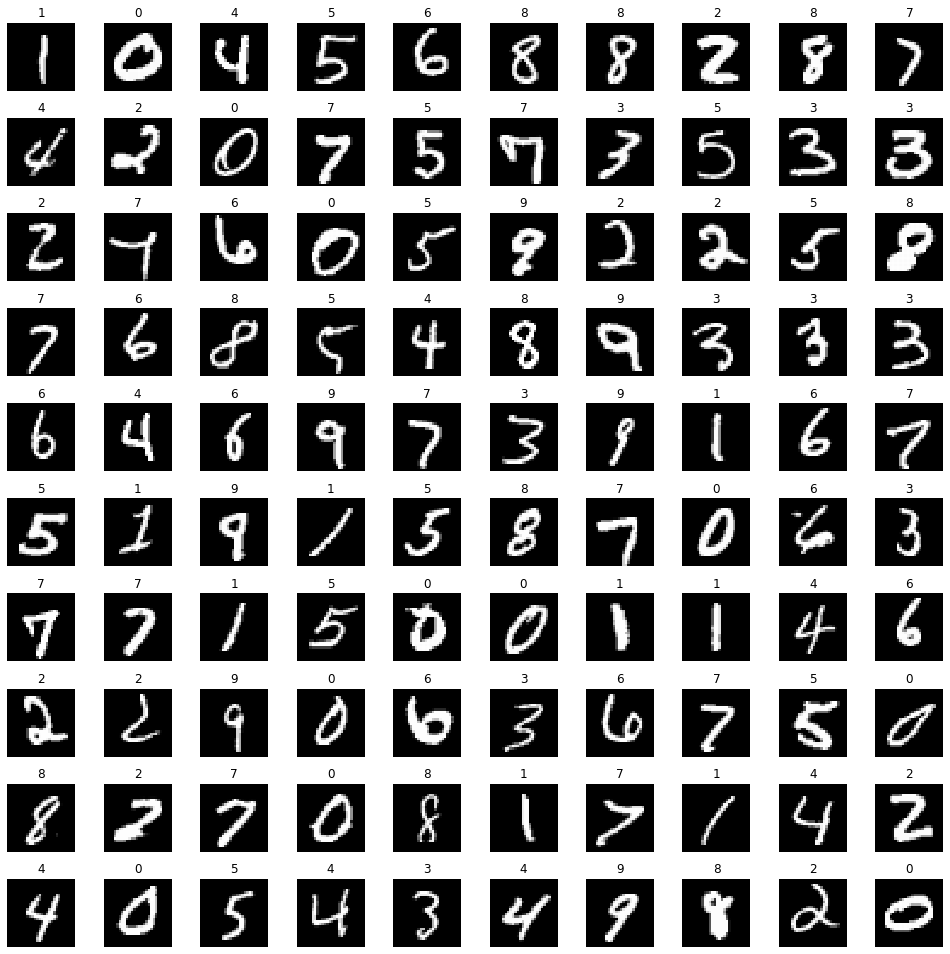

In [ ]:
# Visualize 10 examples of 10 classes. You can extend the following code:
rows, cols = 10, 10
fig,ax = plt.subplots(nrows = rows, ncols = cols, figsize=(17,17))
axis= ax.ravel() #flatten the 10 x 100 matrix into 100 array
n_training= len(x_train)
images= np.array(images)
for i in np.arange(0, rows*cols): #create evenly space variable
    
    #select a random number
    index=np.random.randint(0, n_training)
    #Read and display an image with the selected index
    axis[i].imshow(images[index, 0:].reshape(28,28))
    axis[i].set_title(targets[index], fontsize=12)
    axis[i].axis('off')

plt.subplots_adjust(hspace=0.4)

plt.savefig('fig1.pdf')   # Save the figures
plt.show()   # These should be some visualization of data at the end of this section

# You can see an output example in the follow:

# 2. Digit classifiers

In this section, we'll begin developing models to perform digit classification.


  1. A brief reason which model we are going to train and why we choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define our model
  1. Define optimization method and fit model to data
  1. Summarize our findings







## 2.1: Model [M1]: K-Nearest Neighbors (25 points)

* K-Nearest Neighbors is one of the simplest Machine Learning algorithms based on Supervised Learning technique that captures the idea of similarity, meaning similar things exist in close proximity. K-NN is a non-parametric algorithm, which means it does not make any assumption on underlying data. KNN algorithms decide a number k which is the nearest Neighbor to that data point that is to be classified. If the value of k is 5 it will look for 5 nearest Neighbors to that data point. 
* We choose KNN because its simple and easy to implement, more effective for larger training data and there is a flexibility to choose different distance metrics (Euclidean, Minkowski, Manhattan distance etc.) that is best suited. It is also called a lazy learner algorithm because it does not learn from the training set immediately instead it stores the dataset and at the time of classification, it performs an action on the dataset. This property of KNN makes the computation faster and eventually it takes less time for training.

### 2.1.1: Hyper-parameters

Defining hyper-parameters for our model here

In [ ]:
# hyperparameters for KNN
n_neighbors = [1,3,5,7,10]
leaf_size= [10,20,30,40]

test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation
index_trainval= list(x_trainval.index.values) 
if test_set == 'val':
    train_idxs, val_idxs = 10000, 15000 # Fill in
    x_train, y_train = x_trainval[0: train_idxs], y_trainval[0: train_idxs]
    x_eval, y_eval = x_trainval[train_idxs: val_idxs], y_trainval[train_idxs: val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test



### 2.1.2: Data Preprocessing


In [ ]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_eval = scaler.transform(x_eval)



### 2.1.3: Model

Defining our model here

In [ ]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()

### 2.1.4: Fit Model

Defining optimization procedure and fit our model to the data

In [ ]:
neigh.fit(x_train, y_train)

KNeighborsClassifier()

### 2.1.5: Evaluation

Evaluate our model.
  * Evaluate models with different parameters 
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [ ]:
#Accuracy of base model
neigh.score(x_eval, y_eval)

0.9154

In [ ]:
#Tuning the hyperparameters using Grid Search
param_grid = dict(n_neighbors=n_neighbors, leaf_size=leaf_size)
grid= GridSearchCV(neigh, param_grid, refit= True, verbose=4, cv=3, n_jobs=1)
grid.fit(x_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END ....................leaf_size=10, n_neighbors=1; total time=   0.6s
[CV 2/3] END ....................leaf_size=10, n_neighbors=1; total time=   0.5s
[CV 3/3] END ....................leaf_size=10, n_neighbors=1; total time=   0.5s
[CV 1/3] END ....................leaf_size=10, n_neighbors=3; total time=   0.5s
[CV 2/3] END ....................leaf_size=10, n_neighbors=3; total time=   0.5s
[CV 3/3] END ....................leaf_size=10, n_neighbors=3; total time=   0.5s
[CV 1/3] END ....................leaf_size=10, n_neighbors=5; total time=   0.7s
[CV 2/3] END ....................leaf_size=10, n_neighbors=5; total time=   0.7s
[CV 3/3] END ....................leaf_size=10, n_neighbors=5; total time=   0.6s
[CV 1/3] END ....................leaf_size=10, n_neighbors=7; total time=   0.7s
[CV 2/3] END ....................leaf_size=10, n_neighbors=7; total time=   0.7s
[CV 3/3] END ....................leaf_size=10, n

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'leaf_size': [10, 20, 30, 40],
                         'n_neighbors': [1, 3, 5, 7, 10]},
             verbose=4)

In [ ]:
#Best hyperparameters
print(grid.best_params_)

{'leaf_size': 10, 'n_neighbors': 5}


In [ ]:
y_pred= grid.predict(x_eval)

#Save the final model
dump(grid, 'KNN.joblib')

['KNN.joblib']

In [ ]:
parameters= grid.cv_results_['params']
accuracy=grid.cv_results_['mean_test_score']
par=[]
for i in parameters:
    s= str(i)
    par.append(s)

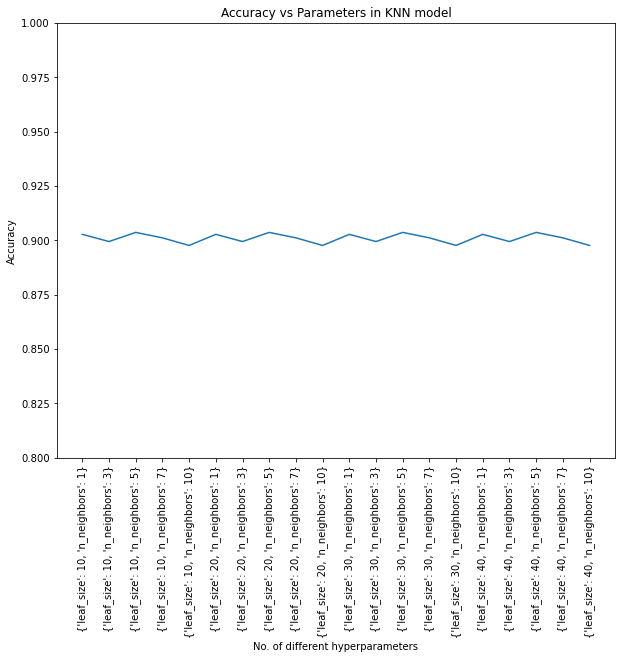

In [ ]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.
plot_scores(par, accuracy, title = "Accuracy vs Parameters in KNN model", x_label = "No. of different hyperparameters", y_label = "Accuracy")


In [ ]:
# Here report the score for the best model
print("The best model score having hyperparameter {} is:".format(grid.best_params_),max(accuracy))

The best model score having hyperparameter {'leaf_size': 10, 'n_neighbors': 5} is: 0.9035999280791908


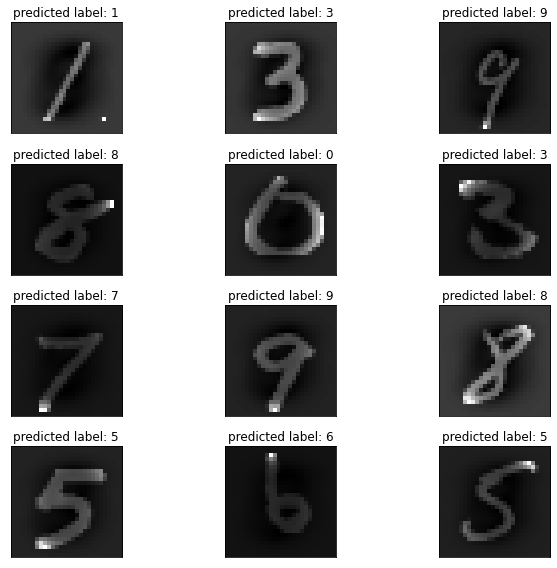

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
vis_predictions(x_eval, y_pred, len(x_eval))


### 2.1.6: Summary

Summarize our findings:
 * Which hyper-parameters were important and how did they influence our results?
 * What were other design choices we faced?
 * other interesting insights...

### Findings

* The number of leaf nodes and the number of neighbors are the two most important hyper-parameters for the KNN model. We got the best accuracy for the following parameter values: Leaf_size = 10 and Number of neighbors = 5. From the above graph, we can observe that the accuracy is maximum for the number of neighbors = 5 for any number of leaf nodes ie, 10, 20, 30, 40. Also, accuracy is decreasing as the number of leaf nodes are increasing.

* At low K values, there is chance of overfitting of data/high variance. Therefore test accuracy is low and train accuracy is high. At K=1 in train data, the error is always zero, because the nearest neighbor to that point is that point itself. Therefore though training error is low test error is high at lower K values. Therefore, as k value increases the test error will decrease and accuracy will increase. But, again higher value of K can lead to underfitting problem. So, to choose a optimal value of K we have used Grid Search algorithim.

# 2.2: Model [M2]: Support Vector Machine

* Support Vector Machines are supervised machine learning algorithms that is used to find a hyperplane in an N-dimensional space that distinctly classifies the data points. SVM works with the help of support vectors that are sample data points closest to the hyperplane. These data points will define the separating line or hyperplane better by calculating margins. In SVMs, we try to maximize the separation gap so that we get maximum margin. A margin is a separation gap between the two lines on the closest data points that is calculated as the perpendicular distance from the line to support vectors or closest data points.

* We chose SVM as it works really well with a clear margin of separation, effective in high dimensional spaces. And last but not the least SVM can work well with image data as well.

### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [ ]:
C= [0.1, 1, 10, 100]
gamma= [1, 0.1, 0.01, 0.001]
kernel=['linear','rbf']

### 2.2.2: Data Preprocessing


In [ ]:
# Using from 2.1.2


### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)

In [ ]:
# Using SVM Classifier
from sklearn.svm import SVC
clf = SVC()


### 2.2.4: Fit Model


In [ ]:
clf.fit(x_train, y_train)

SVC()

### 2.2.5: Evaluation

Evaluate our model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [ ]:
#Accuracy of base model
from sklearn import metrics
y_predict_svm= clf.predict(x_eval)
print(metrics.accuracy_score(y_eval,y_predict_svm))

0.9392


In [ ]:
#Tuning the hyperparameters using Grid Search
from sklearn.model_selection import GridSearchCV
param_grid_svm = dict(C=C, gamma=gamma, kernel=kernel)
grid_svm= GridSearchCV(clf, param_grid_svm, refit= True, verbose=4, cv=3)
grid_svm.fit(x_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END ..................C=0.1, gamma=1, kernel=linear; total time=   3.7s
[CV 2/3] END ..................C=0.1, gamma=1, kernel=linear; total time=   3.7s
[CV 3/3] END ..................C=0.1, gamma=1, kernel=linear; total time=   3.7s
[CV 1/3] END .....................C=0.1, gamma=1, kernel=rbf; total time=  33.3s
[CV 2/3] END .....................C=0.1, gamma=1, kernel=rbf; total time=  33.8s
[CV 3/3] END .....................C=0.1, gamma=1, kernel=rbf; total time=  34.2s
[CV 1/3] END ................C=0.1, gamma=0.1, kernel=linear; total time=   3.6s
[CV 2/3] END ................C=0.1, gamma=0.1, kernel=linear; total time=   3.7s
[CV 3/3] END ................C=0.1, gamma=0.1, kernel=linear; total time=   3.7s
[CV 1/3] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=  31.2s
[CV 2/3] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=  31.4s
[CV 3/3] END ...................C=0.1, gamma=0.1

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=4)

In [ ]:
#Best hyperparameters
print(grid_svm.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
y_pred_svm= grid_svm.predict(x_eval)

#Save the final model
dump(grid_svm, 'SVC.joblib')

['SVC.joblib']

In [ ]:
parameters= grid_svm.cv_results_['params']
accuracy=grid_svm.cv_results_['mean_test_score']
par=[]
for i in parameters:
    s= str(i)
    par.append(s)

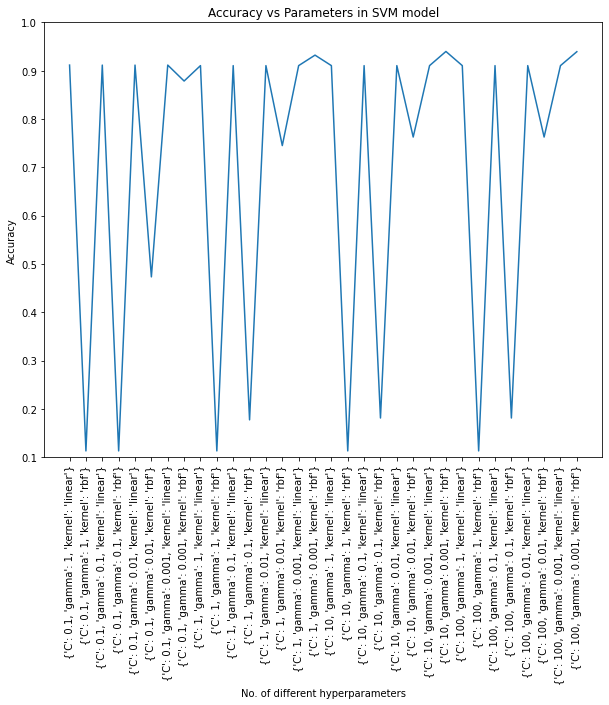

In [ ]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.
plot_scores(par, accuracy, title = "Accuracy vs Parameters in SVM model", x_label = "No. of different hyperparameters", y_label = "Accuracy")


In [ ]:
# Here report the score for the best model
print("The best model score having hyperparameter {} is:".format(grid_svm.best_params_),max(accuracy))

The best model score having hyperparameter {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} is: 0.9398999887991198


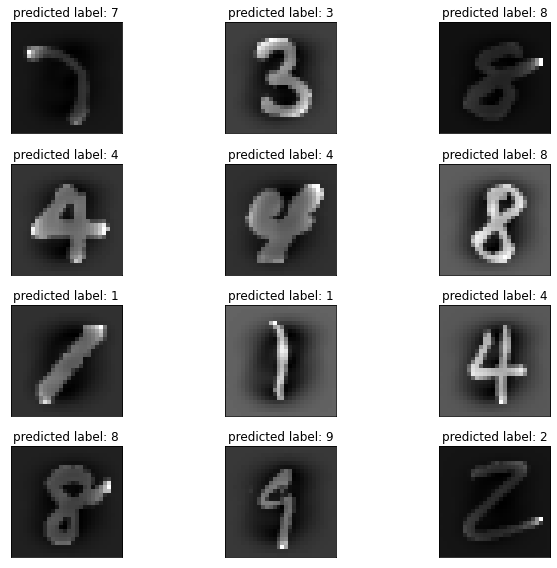

In [ ]:
# Visualize the predictions
vis_predictions(x_eval, y_pred_svm, len(x_eval))

### 2.2.6: Summary

Summarize our findings:
 * Which hyper-parameters were important and how did they influence our results?
 * What were other design choices we faced?
 * other interesting insights...

### Findings

* The important hyper-parameters for the SVM classifier are considered to be kernel, regularization parameter(C) and gamma. The kernel maps the observations into some feature space that are more easily separable after the transformation. There are multiple standard kernels for this transformations, e.g. the linear kernel, the polynomial kernel and the radial basis function kernel. The choice of the kernel and their hyperparameters affect greatly the separability of the classes (in classification) and the performance of the algorithm. 

* The regularization parameter C in SVM is used to control the error.The value of C determines the penalty for the classifier. If C is small, the penalty for misclassified points is low so a decision boundary thus less accuracy. If C is large, SVM tries to minimize the number of misclassified examples due to the high penalty thus high accuracy.

* Gamma decides that how much curvature we want in a decision boundary. Low values of Gamma indicate a large similarity radius which results in more points being grouped together. For High values of Gamma, the points need to be very close to each other in order for it to be considered in the same group. And Gamma only works with rbf kernal.

* Again we used Grid Search to find the optimal parameters and we got the best accuracy of 93.98 % with {C: 10, gamma:0.001, and kernal: rbf}. 

* An intresting insight we can observe from the above graph is that the accuracy is high for lower C with linear kernal while its opposite with rbf kernal. 

# 2.3: Model [M3] (Neural Networks): 

* Here, we use CNN's as they are the latest standards used for classification tasks w.r.t images. A Convolutional neural network (CNN) is a neural network that has one or more convolutional layers and are used mainly for image processing, classification, segmentation and also for other auto correlated data. CNNs are used for image classification and recognition because of its high accuracy. It was proposed by computer scientist Yann LeCun in the late 90s and also has high experimental results on MNIST dataset using LeNet5.



### 2.3.1: Hyper-parameters

Define hyper-parameters for our method here

In [ ]:
# other parameters ...
batch_size=64
test_batch_size=1000
epochs=20
lr=0.1
momentum=0.5
log_interval=10
seed=torch.manual_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/MLCS'
%pwd

/content/drive/MyDrive/MLCS


'/content/drive/MyDrive/MLCS'

### 2.3.2: Data Preprocessing


In [ ]:
def get_train_valid_loader(random_seed, valid_size=0.1, shuffle=True):
    
    # convert data to torch.FloatTensor
    transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
    train_dataset = datasets.MNIST( root='../data', train=True, download=True, transform=transform)
    valid_dataset = datasets.MNIST( root='../data', train=True, download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=test_batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(shuffle=True):
    transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
    test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=shuffle)
    return test_loader

### 2.3.3: Model

Define our model here

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define two convolutional layers, and three fully connected layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5))
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pool with kernel size 2 on the convolutional layers
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2,2))

        # Use cross-entropy instead of MSE for classification loss
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### 2.2.4: Fit Model


In [ ]:
# Example: net = Net(), ....
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
def train(model, optimizer, epoch, loader):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() # Removes all past gradient run info (clean up)
        output = model(data) # Runs the model
        loss = F.nll_loss(output, target) # Computes the loss function (negative log-loss of the softmax output)
        loss.backward() # Run backprop to update weights
        optimizer.step() # Take a step in the right direction of the SGD

        # Logging
        length = len(loader.dataset)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(loader.dataset),100. * batch_idx / len(loader), loss.data))
     


In [ ]:
Accuracy=[]
def test(model, loader, name):
    test_loss = 0
    correct = 0
    for data, target in loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data) # Runs the model
        test_loss += F.nll_loss(output, target, size_average=False).item() # Sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # Get the index (label) of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    # Logging
    length = len(list(loader)) * test_batch_size
    test_loss /= length
    print('\n', name, 'set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, length,100. * correct / length))
    accu=float(correct/length)
    Accuracy.append(accu)
    print(name,' set Accuracy over the epochs',Accuracy)
    return test_loss

In [ ]:
# Save your model using torch.save()

# Load training, validation, and testing data
train_loader, valid_loader = get_train_valid_loader(seed)
test_loader = get_test_loader()
min_loss = sys.float_info.max
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# Run epochs and save model with best performance on the validation set
Epoch=[]
Loss=[]

for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader) #we first train the model
    loss = test(model, valid_loader, 'Validation') # the defined test funtion, returns the loss and hence we first test on validation set and save the best model
    if loss < min_loss: #checks if the loss is less enough to save the model with least loss
        min_loss = loss
        torch.save(model, 'best_model.pt') # Save your model using torch.save()
    Epoch.append(epoch) 
    Loss.append(loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291416
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.267006
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.152856
Train Epoch: 1 [1920/60000 (4%)]	Loss: 1.171788
Train Epoch: 1 [2560/60000 (5%)]	Loss: 2.065329
Train Epoch: 1 [3200/60000 (6%)]	Loss: 1.236744
Train Epoch: 1 [3840/60000 (7%)]	Loss: 0.894744
Train Epoch: 1 [4480/60000 (8%)]	Loss: 2.099591
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.043369
Train Epoch: 1 [5760/60000 (11%)]	Loss: 0.449467
Train Epoch: 1 [6400/60000 (12%)]	Loss: 0.585849
Train Epoch: 1 [7040/60000 (13%)]	Loss: 0.324028
Train Epoch: 1 [7680/60000 (14%)]	Loss: 0.243423
Train Epoch: 1 [8320/60000 (15%)]	Loss: 0.359127
Train Epoch: 1 [8960/60000 (17%)]	Loss: 0.277794
Train Epoch: 1 [9600/60000 (18%)]	Loss: 0.232480
Train Epoch: 1 [10240/60000 (19%)]	Loss: 0.192863
Train Epoch: 1 [10880/60000 (20%)]	Loss: 0.318375
Train Epoch: 1 [11520/60000 (21%)]	Loss: 0.383452
Train Epoch: 1 [12160/60000 (23%)]	Loss: 0.170776
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Validation set: Average loss: 0.0962, Accuracy: 5819/6000 (97%)

Validation  set Accuracy over the epochs [0.9698333144187927]
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.046737
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.077057
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.043311
Train Epoch: 2 [1920/60000 (4%)]	Loss: 0.179212
Train Epoch: 2 [2560/60000 (5%)]	Loss: 0.120741
Train Epoch: 2 [3200/60000 (6%)]	Loss: 0.009614
Train Epoch: 2 [3840/60000 (7%)]	Loss: 0.015333
Train Epoch: 2 [4480/60000 (8%)]	Loss: 0.018969
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.006844
Train Epoch: 2 [5760/60000 (11%)]	Loss: 0.013339
Train Epoch: 2 [6400/60000 (12%)]	Loss: 0.073069
Train Epoch: 2 [7040/60000 (13%)]	Loss: 0.033040
Train Epoch: 2 [7680/60000 (14%)]	Loss: 0.024197
Train Epoch: 2 [8320/60000 (15%)]	Loss: 0.022415
Train Epoch: 2 [8960/60000 (17%)]	Loss: 0.098481
Train Epoch: 2 [9600/60000 (18%)]	Loss: 0.007449
Train Epoch: 2 [10240/60000 (19%)]	Loss: 0.112747
Train Epoch: 2 [10880/60000 (20%)]	Loss: 0.216470


### 2.2.5: Evaluation

Evaluate our model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for our model

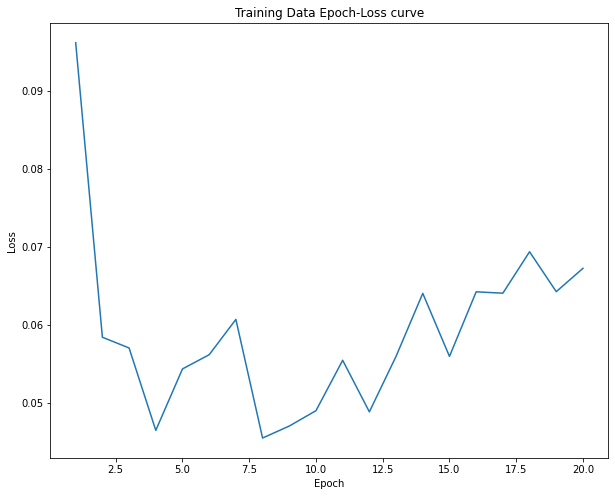

In [ ]:
# Here plot epoch (# passes over training data) and loss
plt.title("Training Data Epoch-Loss curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(Epoch,Loss)
plt.show()

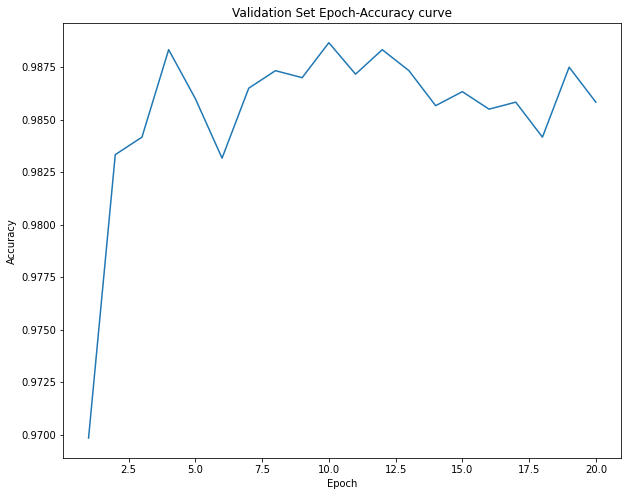

In [ ]:
# Here plot epoch and accuracy over val/test set
plt.title("Validation Set Epoch-Accuracy curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(Epoch,Accuracy[:epochs])
plt.show()

In [ ]:
# Example:
# net = Net()
best_model = torch.load('best_model.pt')

In [ ]:
# Here report the score for the best model
# Using model with the lowest validation set loss on test data
test(best_model, test_loader, 'Test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Test set: Average loss: 0.0418, Accuracy: 9874/10000 (99%)

Test  set Accuracy over the epochs [0.9698333144187927, 0.9833333492279053, 0.98416668176651, 0.9883333444595337, 0.9860000014305115, 0.9831666946411133, 0.9865000247955322, 0.987333357334137, 0.9869999885559082, 0.9886666536331177, 0.9871666431427002, 0.9883333444595337, 0.987333357334137, 0.9856666922569275, 0.9863333106040955, 0.9854999780654907, 0.9858333468437195, 0.98416668176651, 0.987500011920929, 0.9858333468437195, 0.9873999953269958]


0.04184691333770752

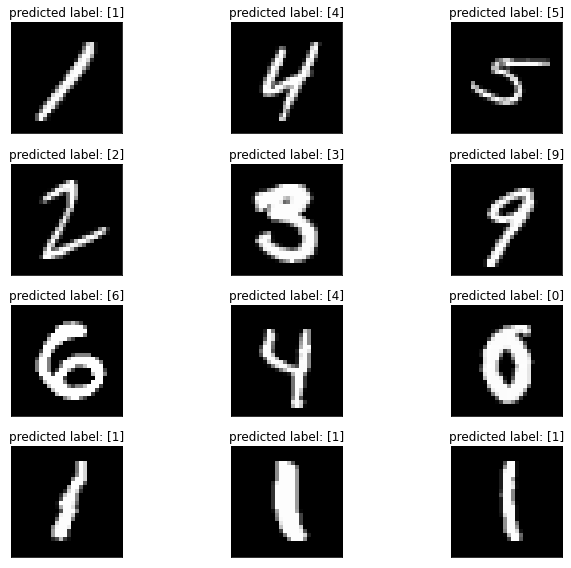

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
for data, target in test_loader:
  x_eval = torch.squeeze(data)
  n_val=len(data)
  output = model(data)
  pred = output.data.max(1, keepdim=True)[1]
vis_predictions(x_eval.numpy(), pred.numpy(), n_val)

### 2.3.6: Summary

Summarize our findings:
 * Which hyper-parameters were important and how did they influence our results?
 * What were other design choices we faced?
 * other interesting insights...

### Solution:- 
The explaination of the model 3 is given in the comments alongside with the code.
 * Learning Rate,Number of Epochs, Activations Functions and Batch size are the main hyperparameters in the CNN model that we have used. Learning rate controls the step size for a model to reach the minimum loss function. A higher learning rate makes the model learn faster, but it may miss the minimum loss function and only reach the surrounding of it. A lower learning rate gives a better chance to find a minimum loss function. As a tradeoff lower learning rate needs higher epochs, or more time and memory capacity resources.Hence we choose a learning rate that is not too low or high hence we chose 0.1 as it is ideal for SGD.The activation function decides how to compute the input values of a layer into output values. The output values of a layer are then passed to the next layer as input values again. Therefore ReLu  overcomes the vanishing gradient problem, allowing models to learn faster and perform better. The rectified linear activation is the default activation when developing multilayer Perceptron and convolutional neural networks.To make the model learn faster, we assign batch size so that not all of the training data are given to the model at the same time. Batch size is the number of training data sub-samples for the input.Our training batch size is 64 and our test batch size is 1000.The smaller batch size makes the learning process faster, but the variance of the validation dataset accuracy is higher. A bigger batch size has a slower learning process, but the validation dataset accuracy has a lower variance.Hence, to best fit our model, we used small batch size for training to learn the model and set it high for testing.
 * There is no generic way to determine a best number of neurons and number of layers for a neural network, given just a problem description.The most common approach seems to be to start with a rough guess based on prior experience about networks used on similar problems.
 * Here, we tried to implement MLP but including the structure of LeNet5 which is one of the oldest classic architectures, gave us far better results because it was one of the earliest architecture used for recognizing the handwritten and machine-printed characters. 

# 3. Summary 

Our final summary here.

comparing performance  on the three models [M1], [M2] and [M3]. 
Which model do we recommend to perform digit classification and why?



### Comparision:


On seeing the above results, we can conclude that Neural Networks work better on Digit classification problems. Most standard implementations of neural networks achieve an accuracy of ~(98–99) percent in correctly classifying the handwritten digits.Beyond this number, every single decimal increase in the accuracy percentage is hard but we still are at the max. expectation of the results. when taken a look at svm, we have an accuracy of appr. 93% and at last, we have KNN with the least having appr. 90% accuracy comparitively. KNN works well with a small number of input variables, but struggles when the number of inputs is very large hence it is advised to be used when the data is less that 40,000/50,000. Whereas in SVM, SVM take cares of outliers better than KNN hence having a slight improvement in the results but again, normal SVM is not suitable for classification of large data sets, because the training complexity of SVM is highly dependent on the size of data set. In Neural Networks, there is a lot of freedom to choose and work the models out. Any basic simple NN could give us a better result than KNN and SVM according to our findings. Also, not to mention that LeNet5 which is one of the oldest classic architectures, gave us far better results because it was one of the earliest architecture used for recognizing the handwritten and machine-printed characters gives results beyond expectation for a network that simple and easy.